# Setup
YouTube Data API key  
https://developers.google.com/youtube/v3/getting-started  

Gemini Pro API Key  
https://ai.google.dev/pricing  
https://makersuite.google.com/app/apikey

Put keys into Colab's Secrets store.

In [ ]:
from google.colab import userdata
YOUTUBE_DATA_API_KEY = userdata.get('YOUTUBE_DATA_API_KEY')
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
# Colab already has google libraries installed
# Reference: https://developers.google.com/youtube/v3/quickstart/python
# !pip install --upgrade google-api-python-client
# !pip install --upgrade google-auth-oauthlib google-auth-httplib2

!pip install youtube-transcript-api

# Colab already has Gemini libraries installed
# Reference: https://ai.google.dev/tutorials/python_quickstart?hl=en
# !pip install -q -U google-generativeai

In [ ]:
# YouTube Data API
import googleapiclient.discovery

# For displaying videos in Colab
from IPython.display import YouTubeVideo

# YT Transcripts
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter

# Gemini API
import google.generativeai as genai


# Functions to Search YouTube

In [ ]:
youtube = googleapiclient.discovery.build(serviceName='youtube', version='v3', developerKey=YOUTUBE_DATA_API_KEY)

genai.configure(api_key=GEMINI_API_KEY)
genai_model = genai.GenerativeModel('gemini-pro')

def search_yt(query, max_results=5, page_token=None):

    # Reference: https://developers.google.com/youtube/v3/docs/search/list
    # Reference: https://developers.google.com/youtube/v3/guides/implementation/pagination
    request = youtube.search().list(
        part="snippet", # search by keyword
        maxResults=max_results,
        pageToken=page_token, # optional, for going to next/prev result page
        q=query,
        videoCaption='closedCaption', # only include videos with captions
        type='video',   # only include videos, not playlists/channels
    )
    response = request.execute()
    search_response = Search_Response(response)
    return search_response

# Display YouTube search results
def display_yt_results(search_response, extract_prompt=None):
  for search_result in search_response.search_results:
      print(f'Video ID: {search_result.video_id}')
      print(f'Title: {search_result.title}')
      youtube_video = YouTubeVideo(search_result.video_id)
      display(youtube_video)

      if(extract_prompt is not None):
        transcript = get_transcript(search_result.video_id)
        extracted_text, _, _ = get_ai_extract(extract_prompt, transcript)
        print(extracted_text)

      print()

# Get transcript from YouTube video
# Reference: https://github.com/jdepoix/youtube-transcript-api
def get_transcript(video_id, languages=['en','en-US','en-GB']):
    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=languages)
    transcript = TextFormatter().format_transcript(transcript)

    # print(transcript)
    return transcript

# Extract information from text based on prompt instructions
def get_ai_extract(prompt, text):
    response = genai_model.generate_content(prompt + text, stream=False)
    return response.text, response.prompt_feedback, response.candidates

In [ ]:
transcript = get_transcript("YYUhtNe8sBg")

recipe, _, _ = get_ai_extract("Extract cooking recipe from video transcript: ", transcript)

print(recipe)

**Ingredients:**

- 2 slices of fluffy bread
- Cheese
- Sandwich ham
- Cheese (again)
- 1 tbsp mayonnaise (or 12g butter)
- 2 eggs
- Salt and pepper
- 100g mozzarella cheese
- Minced garlic (2/3 tsp)
- Honey (1 tbsp)
- Other type of shredded cheese (optional)
- Parsley (for garnish)

**Instructions:**

1. Press the bread with a cup to flatten it.
2. Apply mayonnaise (or butter) on one side of each slice of bread.
3. Place cheese, ham, and cheese on one slice of bread.
4. Top with the other slice of bread, mayonnaise (or butter) side down.
5. Crack the eggs into the cup you used to press the bread.
6. Add salt, pepper, and garlic to the eggs.
7. Pour the eggs into the center of the sandwich.
8. Surround the egg with mozzarella cheese.
9. Make holes in the yolk of the egg.
10. Top with honey (if using the mayonnaise version).
11. Preheat the oven to 180°C (355°F).
12. Bake the sandwich for 15 minutes.
13. If the egg is undercooked, leave it in the oven for a few more minutes at a lower t

# Search Response / Results Classes
Classes to extract data from JSON objects.

In [ ]:
'''
Search Response JSON
https://developers.google.com/youtube/v3/docs/videos/list#response
{
    "kind": "youtube#searchListResponse",
    "etag": etag,
    "nextPageToken": string,
    "prevPageToken": string,
    "regionCode": string,
    "pageInfo": {
        "totalResults": integer,
        "resultsPerPage": integer
    },
    "items": [
        search Resource
    ]
}
'''
class Search_Response:
    def __init__(self, search_response) -> None:
        self.prev_page_token = search_response.get('prevPageToken')
        self.next_page_token = search_response.get('nextPageToken')

        # items element contain list of videos
        items = search_response.get('items')

        self.search_results = []
        for item in items:
            search_result = Search_Result(item)
            self.search_results.append(search_result)

'''
Search Results JSON
https://developers.google.com/youtube/v3/docs/search#resource
{
    "kind": "youtube#searchResult",
    "etag": etag,
    "id": {
        "kind": string,
        "videoId": string,
        "channelId": string,
        "playlistId": string
    },
    "snippet": {
        "publishedAt": datetime,
        "channelId": string,
        "title": string,
        "description": string,
        "thumbnails": {
          (key): {
              "url": string,
              "width": unsigned integer,
              "height": unsigned integer
          }
        },
        "channelTitle": string,
        "liveBroadcastContent": string
    }
}
'''
class Search_Result:
    def __init__(self, search_result) -> None:
        self.video_id=     search_result['id']['videoId']
        self.title=        search_result['snippet']['title']
        self.description=  search_result['snippet']['description']
        self.thumbnails=   search_result['snippet']['thumbnails']['default']['url']


# Search YouTube and Display Results

Video ID: 3s7opUfsin8
Title: 1 Tomato with 3 eggs! Quick breakfast in 5 minutes. Super easy and delicious omelet recipe


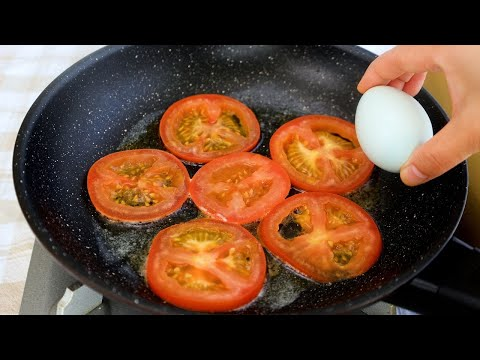

Omelet Recipe:

Ingredients:

- 3 Eggs
- Salt
- Black Pepper
- Crushed Red Pepper
- 100g Green Onion (Chopped)
- 1 Tbsp Unsalted Butter
- 1 Tomato (Sliced)
- Mozzarella Cheese

Instructions:

1. In a bowl, mix together the eggs, salt, black pepper, and crushed red pepper.
2. Add the chopped green onion to the egg mixture and mix well.
3. Heat a pan over medium-low heat and add the unsalted butter.
4. Place the sliced tomato slices in the pan.
5. Pour the egg mixture over the tomato slices.
6. Sprinkle mozzarella cheese on top of the egg mixture.
7. Fry the omelet for 3-5 minutes until cooked through.
8. Serve immediately.

Enjoy your delicious omelet for breakfast!

Video ID: 9-ODDKHRVkA
Title: The Best Scrambled Eggs You&#39;ll Ever Make (Restaurant-Quality) | Epicurious 101


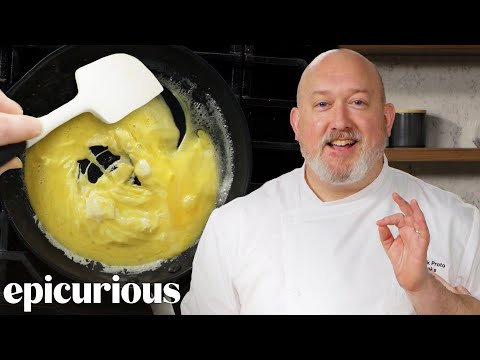

**Ingredients:**

* 3 eggs
* Unsalted butter
* Salt
* Black pepper (optional)

**Instructions:**

1. Remove eggs from the fridge 15-20 minutes before cooking to whisk better and cook quicker.
2. Whisk eggs in a bowl with a fork until just combined (no extra air).
3. Preheat a non-stick pan over medium heat.
4. Add a generous amount of unsalted butter to coat the bottom of the pan.
5. Pour eggs into the pan when the butter is not fully melted yet.
6. Add salt while the eggs are still liquid so that it melts into them.
7. Stir eggs gently to create curds of your desired size.
8. Stop cooking when eggs are no longer liquidy but still slightly creamy and shiny.
9. Remove eggs from the pan and transfer to a plate.
10. (Optional) season with black pepper and spread a small knob of butter over the eggs to add richness.

**Tips:**

- To make sure the eggs don’t stick to the pan, make sure to preheat the pan before adding the eggs.
- For extra creamy scrambled eggs, use more butter.
- Don’t ove

In [ ]:
# Search YouTube and display results
search_response = search_yt('egg recipes', max_results=2)
display_yt_results(search_response, 'Extract cooking recipe from video transcript: ')

In [ ]:
# Go to next page
search_response = search_yt('egg recipes', max_results=2, page_token=search_response.next_page_token)
display_yt_results(search_response, extract_prompt='Extract cooking recipe from video transcript: ')